In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from functions import function_loss, gradient, LMO, FW_standard, FW_pairwise, FW_line_search



# Path to dataset
file_path =  r"c:\Users\utente13\Desktop\netflix\combined_data_1.txt" 

# Lists to store data
user_ids = []
movie_ids = []
ratings = []
timestamps = []

# Read the dataset line by line
with open(file_path, "r") as f:
    movie_id = None
    for line in f:
        line = line.strip()
        if line.endswith(":"):
            movie_id = int(line[:-1])  # Extract MovieID
        else:
            user_id, rating, timestamp = line.split(",")
            user_ids.append(int(user_id))
            movie_ids.append(movie_id)
            ratings.append(int(rating))
            timestamps.append(timestamp)

# Convert to Pandas DataFrame
df = pd.DataFrame({"UserID": user_ids, "MovieID": movie_ids, "Rating": ratings, "Timestamp": timestamps})

# Save processed data
df.to_csv("processed_netflix_data.csv", index=False)

# Display first few rows
print(df.head())

print("*" * 60)
print("DF INFORMATIONS")
print("*" * 60)
df.info()


    UserID  MovieID  Rating   Timestamp
0  1488844        1       3  2005-09-06
1   822109        1       5  2005-05-13
2   885013        1       4  2005-10-19
3    30878        1       4  2005-12-26
4   823519        1       3  2004-05-03
************************************************************
DF INFORMATIONS
************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24053764 entries, 0 to 24053763
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   UserID     int64 
 1   MovieID    int64 
 2   Rating     int64 
 3   Timestamp  object
dtypes: int64(3), object(1)
memory usage: 734.1+ MB


In [2]:
df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [3]:
print(f"Total Unique Users: {df['UserID'].nunique()}")
print(f"Total Unique Movies: {df['MovieID'].nunique()}")

Total Unique Users: 470758
Total Unique Movies: 4499


In [4]:
min_ratings = 20 

# Count ratings per user
user_rating_counts = df.groupby("UserID")["MovieID"].count()

# Filter users with at least `min_ratings`
valid_users = user_rating_counts[user_rating_counts >= min_ratings].index
df = df[df["UserID"].isin(valid_users)]

In [5]:
df["UserID"] = df["UserID"].astype("category").cat.codes
df["MovieID"] = df["MovieID"].astype("category").cat.codes

In [6]:
num_users = df["UserID"].nunique()
num_movies = df["MovieID"].nunique()
total_possible_ratings = num_users * num_movies
actual_ratings = len(df)

sparsity = (1 - (actual_ratings / total_possible_ratings)) * 100
print(f"Dataset Sparsity: {sparsity:.2f}%")


Dataset Sparsity: 98.10%


In [7]:
def create_rating_matrix(df, max_users=None, max_movies=None):
    """
   Creating matrix user-movie 
    """
    df_subset = df.copy()
    
    if max_users:
        top_users = df_subset['UserID'].value_counts().head(max_users).index
        df_subset = df_subset[df_subset['UserID'].isin(top_users)]
    if max_movies:
        top_movies = df_subset['MovieID'].value_counts().head(max_movies).index
        df_subset = df_subset[df_subset['MovieID'].isin(top_movies)]
    
    # Mapping user_id/movie_id -> matrix index
    user_ids = sorted(df_subset['UserID'].unique())
    movie_ids = sorted(df_subset['MovieID'].unique())
    
    user_map = {uid: i for i, uid in enumerate(user_ids)}
    movie_map = {mid: i for i, mid in enumerate(movie_ids)}
    
    # Initializing empty matrix
    n_users = len(user_ids)
    n_movies = len(movie_ids)
    R = np.zeros((n_users, n_movies))
    
    # Filling up matriex with observed data
    for _, row in df_subset.iterrows():
        i = user_map[row['UserID']]
        j = movie_map[row['MovieID']]
        R[i, j] = row['Rating']
    
    return R, user_map, movie_map

In [8]:
def train_test_split_matrix(R, test_ratio=0.2, seed=42):
    """
    Splitting entries in test and train
    """
    np.random.seed(seed)
    
    # Finding all observed entries
    rows, cols = R.nonzero()
    n_observed = len(rows)
    
    # Indexing shuffle
    indices = np.random.permutation(n_observed)
    n_test = int(n_observed * test_ratio)
    
    test_idx = indices[:n_test]
    train_idx = indices[n_test:]
    
    # Creating test and train matrices
    R_train = np.zeros_like(R)
    R_test = np.zeros_like(R)
    
    R_train[rows[train_idx], cols[train_idx]] = R[rows[train_idx], cols[train_idx]]
    R_test[rows[test_idx], cols[test_idx]] = R[rows[test_idx], cols[test_idx]]
    
    print(f"Total entries: {n_observed}")
    print(f"Train: {len(train_idx)}, Test: {len(test_idx)}")
    
    return R_train, R_test


In [9]:
def test_loss(R_test, P):
    """
    MSE on entries
    """
    test_indices = R_test.nonzero()
    R_obs = R_test[test_indices]
    P_obs = P[test_indices]
    return np.mean((R_obs - P_obs) ** 2)


In [10]:
#Creating subset

print("Creating matrix...")
R_full, user_map, movie_map = create_rating_matrix(
    df, 
    max_users=500,  
    max_movies=1000  
)

print(f"\nMatrice: {R_full.shape[0]} users × {R_full.shape[1]} movies")
print(f"Observed Ratings: {np.count_nonzero(R_full)}")
print(f"Sparsity: {100 * (1 - np.count_nonzero(R_full) / R_full.size):.2f}%")

Creating matrix...

Matrice: 500 users × 1000 movies
Observed Ratings: 272073
Sparsity: 45.59%


In [11]:
# Train/Test split
R_train, R_test = train_test_split_matrix(R_full, test_ratio=0.2)

# Calcola delta (nuclear norm budget)
_, s, _ = np.linalg.svd(R_train, full_matrices=False)
delta = np.sum(s) * 1.5

print(f"\nNuclear norm R_train: {np.sum(s):.2f}")
print(f"Delta: {delta:.2f}")

Total entries: 272073
Train: 217659, Test: 54414

Nuclear norm R_train: 23683.94
Delta: 35525.91


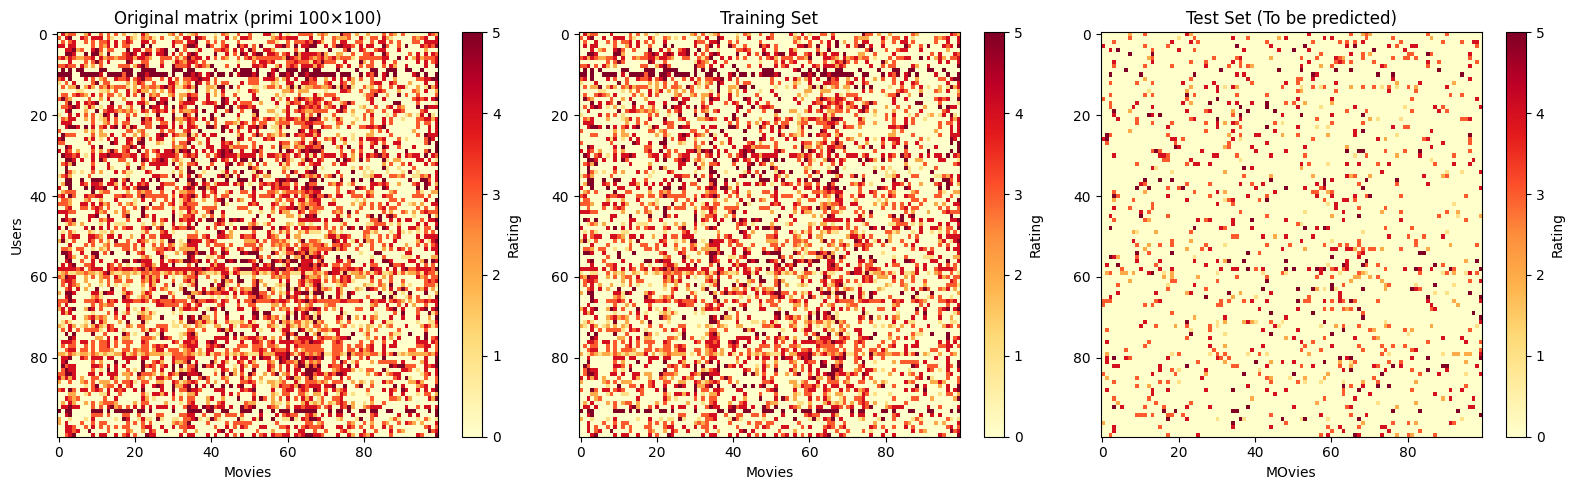

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Complete matrix
im1 = axes[0].imshow(R_full[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[0].set_title('Original matrix (primi 100×100)')
axes[0].set_xlabel('Movies')
axes[0].set_ylabel('Users')
plt.colorbar(im1, ax=axes[0], label='Rating')

# Train matrix
im2 = axes[1].imshow(R_train[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[1].set_title('Training Set')
axes[1].set_xlabel('Movies')
plt.colorbar(im2, ax=axes[1], label='Rating')

# Test matrix
im3 = axes[2].imshow(R_test[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[2].set_title('Test Set (To be predicted)')
axes[2].set_xlabel('MOvies')
plt.colorbar(im3, ax=axes[2], label='Rating')

plt.tight_layout()
plt.show()

In [13]:
MAX_ITER = 150
TOL = 1e-5

# Standard FW
print("=" * 60)
print("TRAINING: Standard Frank-Wolfe")
print("=" * 60)

start_time = time.time()
P_std, loss_history_std, gap_history_std = FW_standard(
    R_train, delta=delta, max_iter=MAX_ITER, tol=TOL
)
train_time_std = time.time() - start_time

print(f"✓ Completed in {train_time_std:.2f}s")
print(f"  Iterations: {len(loss_history_std)}")
print(f"  Train loss: {loss_history_std[-1]:.4f}")

TRAINING: Standard Frank-Wolfe
✓ Completed in 11.23s
  Iterations: 150
  Train loss: 1.1874


In [14]:
print("=" * 60)
print("TRAINING: Frank-Wolfe with Line Search")
print("=" * 60)

start_time = time.time()
P_ls, loss_history_ls, gap_history_ls = FW_line_search(
    R_train, delta=delta, max_iter=MAX_ITER, tol=TOL
)
train_time_ls = time.time() - start_time

print(f"Completed in {train_time_ls:.2f}s")
print(f"Iterations: {len(loss_history_ls)}")
print(f"Train loss: {loss_history_ls[-1]:.4f}")

TRAINING: Frank-Wolfe with Line Search
Completed in 19.21s
Iterations: 150
Train loss: 0.1396


In [15]:
# Pairwise FW
print("=" * 60)
print("TRAINING: Pairwise Frank-Wolfe")
print("=" * 60)

start_time = time.time()
P_pw, loss_history_pw, gap_history_pw = FW_pairwise(
    R_train, delta=delta, max_iter=MAX_ITER, tol=TOL
)
train_time_pw = time.time() - start_time

print(f"Completed in {train_time_pw:.2f}s")
print(f"Iterations: {len(loss_history_pw)}")
print(f"Train loss: {loss_history_pw[-1]:.4f}")

TRAINING: Pairwise Frank-Wolfe


Completed in 75.49s
Iterations: 150
Train loss: 0.1940


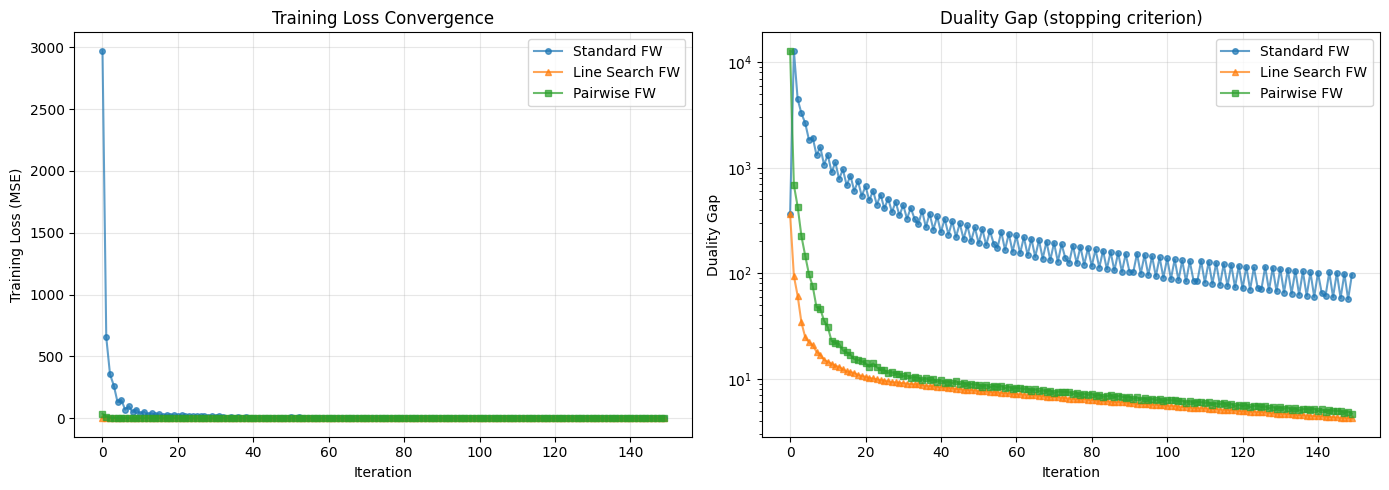

In [16]:

# %%
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
axes[0].plot(loss_history_std, 'o-', label='Standard FW', alpha=0.7, markersize=4)
axes[0].plot(loss_history_ls, '^-', label='Line Search FW', alpha=0.7, markersize=4)
axes[0].plot(loss_history_pw, 's-', label='Pairwise FW', alpha=0.7, markersize=4)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Training Loss (MSE)')
axes[0].set_title('Training Loss Convergence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Duality gap
axes[1].semilogy(gap_history_std, 'o-', label='Standard FW', alpha=0.7, markersize=4)
axes[1].semilogy(gap_history_ls, '^-', label='Line Search FW', alpha=0.7, markersize=4)
axes[1].semilogy(gap_history_pw, 's-', label='Pairwise FW', alpha=0.7, markersize=4)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Duality Gap')
axes[1].set_title('Duality Gap (stopping criterion)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [17]:

test_mse_std = test_loss(R_test, P_std)
test_mse_ls = test_loss(R_test, P_ls)
test_mse_pw = test_loss(R_test, P_pw)

print("=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"{'Method':<20} {'Train MSE':<12} {'Test MSE':<12} {'RMSE':<10} {'Time (s)':<10}")
print("-" * 60)
print(f"{'Standard FW':<20} {loss_history_std[-1]:<12.4f} {test_mse_std:<12.4f} {np.sqrt(test_mse_std):<10.4f} {train_time_std:<10.2f}")
print(f"{'Line Search FW':<20} {loss_history_ls[-1]:<12.4f} {test_mse_ls:<12.4f} {np.sqrt(test_mse_ls):<10.4f} {train_time_ls:<10.2f}")
print(f"{'Pairwise FW':<20} {loss_history_pw[-1]:<12.4f} {test_mse_pw:<12.4f} {np.sqrt(test_mse_pw):<10.4f} {train_time_pw:<10.2f}")

TEST SET RESULTS
Method               Train MSE    Test MSE     RMSE       Time (s)  
------------------------------------------------------------
Standard FW          1.1874       1.0860       1.0421     11.23     
Line Search FW       0.1396       1.0172       1.0086     19.21     
Pairwise FW          0.1940       0.8237       0.9076     75.49     


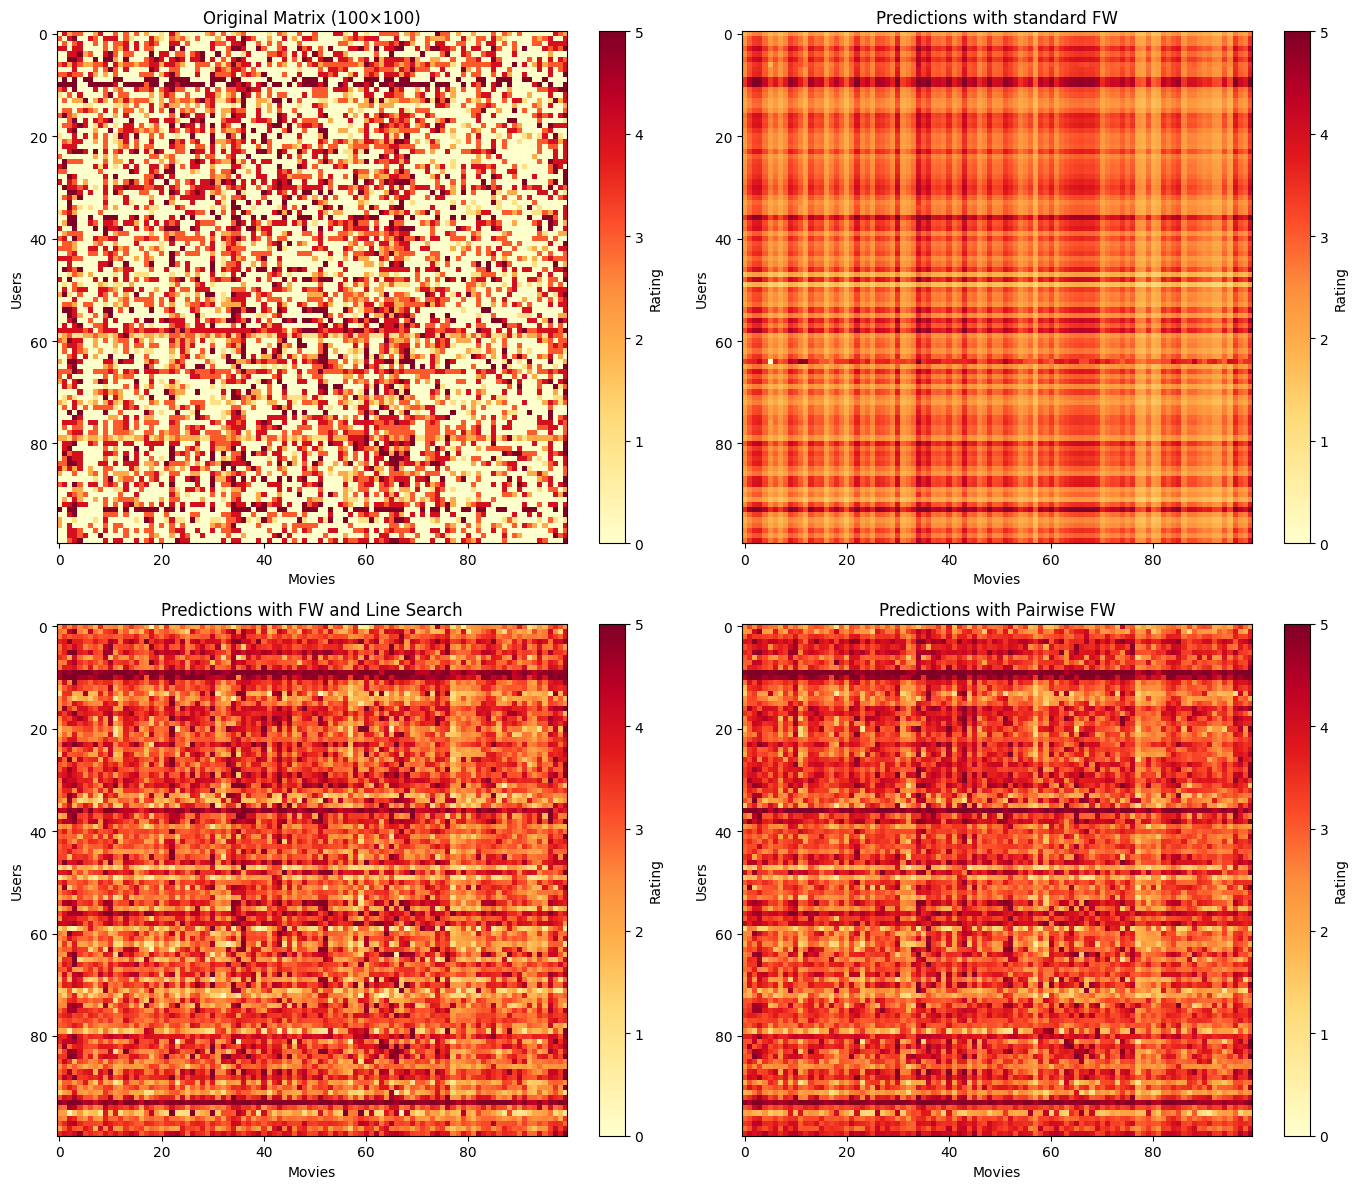

In [20]:
# Confronto: Matrice originale vs Predizioni
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original
im1 = axes[0, 0].imshow(R_full[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[0, 0].set_title('Original Matrix (100×100)')
axes[0, 0].set_xlabel('Movies')
axes[0, 0].set_ylabel('Users')
plt.colorbar(im1, ax=axes[0, 0], label='Rating')

# Prediction Standard FW
im2 = axes[0, 1].imshow(P_std[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[0, 1].set_title('Predictions with standard FW')
axes[0, 1].set_xlabel('Movies')
axes[0, 1].set_ylabel('Users')
plt.colorbar(im2, ax=axes[0, 1], label='Rating')

# Prediction Line Search FW
im3 = axes[1, 0].imshow(P_ls[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[1, 0].set_title('Predictions with FW and Line Search')
axes[1, 0].set_xlabel('Movies')
axes[1, 0].set_ylabel('Users')
plt.colorbar(im3, ax=axes[1, 0], label='Rating')

# Prediction Pairwise FW
im4 = axes[1, 1].imshow(P_pw[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[1, 1].set_title('Predictions with Pairwise FW')
axes[1, 1].set_xlabel('Movies')
axes[1, 1].set_ylabel('Users')
plt.colorbar(im4, ax=axes[1, 1], label='Rating')

plt.tight_layout()
plt.show()
